# Petrophysical Rock Type (PRT) Estimations using Machine Learning

#### This Workbook started with Brendon Hall, [Enthought](https://www.enthought.com/) (1)

This notebook demonstrates how to train a machine learning algorithm to predict facies from well log data.  The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from eight carbonate wells that have been labeled with Petrophysical Rock Types (PRT) called facies in this instance based on Ed Clerke's Rosetta Stone data (2).  We will use this log data to train a support vector machine to classify these PRT facies types.  Support vector machines (or SVMs) are a type of supervised learning model that can be trained on data to perform classification and regression tasks.  The SVM algorithm uses the training data to fit an optimal hyperplane between the different classes (or facies, in our case).  We will use the SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/svm.html).

First we will [explore the dataset](#Exploring-the-dataset).  We will load the training data from 8 wells, and take a look at what we have to work with.  We will plot the data from a couple wells, and create cross plots to look at the variation within the data.  

Next we will [condition the data set](#Conditioning-the-data-set).  We will remove the entries that have incomplete data.  The data will be scaled to have zero mean and unit variance.  We will also split the data into training and test sets.

We will then be ready to [Training the SVM classifier](#Training-the-SVM-classifier).  We will demonstrate how to use the cross validation set to do [model parameter selection](#Model-parameter-selection).

Finally, once we have a built and tuned the classifier, we can [apply the trained model](#Applying-the-classification-model-to-new-data) to classify facies in wells which do not already have labels.  We will apply the classifier to two wells, but in principle you could apply the classifier to any number of wells that had the same log data.

## Exploring the dataset

First, we will examine the data set we will use to train the classifier.  The training data is contained in the file `./data/AMMY_RockIndex_notops.csv`.  The dataset consists of 6 wireline log measurements and a facies label at half foot intervals.  In machine learning terminology, each log measurement is a feature vector that maps a set of 'features' (the log measurements) to a class (the facies type).  We will use the pandas library to load the data into a dataframe, which provides a convenient data structure to work with well log data.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)

filename = './data/AMMY_RockIndex_notops.csv'
training_data = pd.read_csv(filename)
training_data


Bad key "text.kerning_factor" on line 4 in
/Users/craig/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


,Facies,Well Name,Depth,GR,ILD,ILD_log10,NPHI,RHOB,PORD,PORDIFF,BVW
0,6,AMMY220,970.0,6.4491,172.000,2.235528,0.0059,2.8952,-0.115031,0.120931,0.000000
1,6,AMMY220,970.5,5.5320,1681.000,3.225568,0.0059,2.9069,-0.122298,0.128198,0.000000
2,6,AMMY220,971.0,5.3231,2000.000,3.301030,0.0094,2.9300,-0.136646,0.146046,0.000000
3,6,AMMY220,971.5,6.9531,2000.000,3.301030,0.0153,2.9085,-0.123292,0.138592,0.000000
4,6,AMMY220,972.0,8.5964,2000.000,3.301030,0.0356,2.8776,-0.104099,0.139699,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2752,5,AMMY214,2048.0,15.0573,14.186,1.151860,0.0956,2.5860,0.077019,0.018581,0.041980
2753,4,AMMY214,2048.5,15.2678,13.581,1.132932,0.1006,2.5560,0.095652,0.004948,0.042905
2754,4,AMMY214,2049.0,14.6838,13.024,1.114744,0.1065,2.5390,0.106211,0.000289,0.043812
2755,4,AMMY214,2049.5,12.7852,12.474,1.096006,0.1152,2.5340,0.109317,0.005883,0.044768


Remove a single well to use as a blind test later.

In [2]:
blind = training_data[training_data['Well Name'] == 'AMMY137']
training_data = training_data[training_data['Well Name'] != 'AMMY137']

This data is from an Arab D reservoir from the Middle East. This Field is a carbonate oil reservoir encompassing a large area in UAE.  This dataset is from 8 wells, consisting of a set of seven predictor variables and a rock PRT facies (class) for each example vector and validation (test) data (from two wells) having the same seven predictor variables in the feature vector.  PRT Facies are based on Clerke's Rosetta Stone core database. Predictor variables include 6 from wireline log measurements and one Petrophysical constraining variables.

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* The PRTs are from Rosetta Stone PRT work by Clerke

The 6 discrete PRT facies (Petrophysical Rock Types) are: 
1. M_1, Macro Porous Rock with Meso porous grains
2. M_2, Macro Porous Rock with Micro porous grains 
3. M_1_2, Macro Porous Rock with Meso and Micro porous grains 
4. Type1, Meso Porous Rock
5. Type1_2, Meso Porous Rock with Micro porous grains
6. Micro, Micro Porous Rock that is non-reservoir rock


These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |M_1| 2,3,4
2 |M_2| 1,3,4
3 |M_1_2| 2,4
4 |Type1| 1,2,3,5
5 |Type1_2| 4,6
6 |Micro| 4,5


Let's clean up this dataset.  The 'Well Name' and 'Formation' columns can be turned into a categorical data type.  

In [3]:
training_data['Well Name'] = training_data['Well Name'].astype('category')
#training_data['Formation'] = training_data['Formation'].astype('category')
training_data['Well Name'].unique()

/Users/craig/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[AMMY220, AMMY242, AMMY177, AMMY212, AMMY214]
Categories (5, object): [AMMY220, AMMY242, AMMY177, AMMY212, AMMY214]

These are the names of the 7 training wells in this Arab D reservoir.  

Before we plot the well data, let's define a color map so the facies are represented by consistent color in all the plots in this tutorial.  We also create the abbreviated facies labels, and add those to the pandas dataframe.

In [4]:
# 1=M_1  2=M_2   3=M_1_2 
# 4=Type1 5=Type1_2 6=Type2

facies_colors = ['#00FFFF', '#00BFFF','#0000FF','#FFFF00',
       '#FFA500','#A52A2A']

facies_labels = ['M_1', 'M_2', 'M_1_2', 'Meso1', 'Meso1_2',
                 'Micro']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
training_data.loc[:,'FaciesLabels'] = training_data.apply(lambda row: label_facies(row, facies_labels), axis=1)
training_data.describe()

/Users/craig/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/craig/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Facies,Depth,GR,ILD,ILD_log10,NPHI,RHOB,PORD,PORDIFF,BVW
count,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,2.904804,1512.637726,15.422392,100.479263,1.446760,0.167161,2.500695,0.130003,0.037158,0.034318
std,1.824708,397.997619,4.787341,327.966661,0.531470,0.062642,0.117890,0.073224,0.034047,0.016742
min,1.000000,955.000000,5.323100,2.990000,0.475671,0.002300,2.254000,-0.159503,-0.150453,0.000000
25%,1.000000,1104.000000,11.642800,12.627000,1.101300,0.116800,2.399000,0.073851,0.015727,0.022544
50%,3.000000,1677.000000,15.064500,20.994000,1.322095,0.163400,2.509800,0.124348,0.032793,0.034280
75%,4.000000,1896.000000,18.732300,48.469000,1.685464,0.222000,2.591100,0.193168,0.052256,0.044392
max,6.000000,2050.000000,32.888600,2000.000000,3.301030,0.309700,2.966800,0.283230,0.212175,0.091440


This is a quick view of the statistical distribution of the input variables.  Looking at the `count` values, most values have 2269 valid values. We are not using  `PEF`.

In [5]:
#####PE_mask = training_data['PE'].notnull().values
######training_data = training_data[PE_mask]

Let's take a look at the data from individual wells in a more familiar log plot form.  We will create plots for the five well log variables, as well as a log for facies labels.  The plots are based on the those described in Alessandro Amato del Monte's [excellent tutorial](https://github.com/seg/tutorials/tree/master/1504_Seismic_petrophysics_1).

In [6]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    depthscale = round((zbot - ztop)*0.03)
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, 20))
    #f, ax = plt.subplots(nrows=1, ncols=6, figsize=(15, depthscale))
    
    ax[0].plot(logs.GR, logs.Depth, 'k-', linewidth=1.0)
    ax[1].plot(logs.ILD, logs.Depth, 'k--', linewidth=2.0)
    ax[2].plot(logs.PORDIFF, logs.Depth, '-', color='0.5', linewidth=1.0)
    ax[3].plot(logs.PORD, logs.Depth, '-', color='r', label= 'PORD')
    ax[3].plot(logs.NPHI, logs.Depth, 'g--',label= 'NPHI')
    ax[4].plot(logs.PORD, logs.Depth, '-', color='black')
    ax[4].plot(logs.BVW, logs.Depth, '-', color='blue')
    
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=6)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)

    cbar.set_label((45*' ').join(facies_labels))
    #cbar.set_label((45*' ').join(facies_labels))
    #cbar.set_label((depthscale*' ').join(facies_labels))
    
    
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,50)
    ax[0].fill_betweenx(logs.Depth,0,logs.GR,color='green',label= 'GR')

    ax[1].set_xscale('log')
    ax[1].set_xlabel("ILD")
    ax[1].set_xlim(.2,2000)

    ax[2].set_xlabel("PORDIFF")
    ax[2].set_xlim(logs.PORDIFF.max(),logs.PORDIFF.min())
    ax[2].fill_betweenx(logs.Depth,0,logs.PORDIFF,color='lightgray',label= 'Por Diff')
    ax[2].legend(loc='lower left') 

    
    
    ax[3].set_xlabel("PORD/NPHI")
    ax[3].set_xlim(.45,-0.15)
    ax[3].fill_betweenx(logs.Depth,logs.NPHI, logs.PORD,color='lightgray',label= 'Shale')
    ax[3].legend(loc='lower left') 

    ax[4].set_xlabel("Bulk Vol")
    ax[4].set_xlim(.5,0)
    ax[4].fill_betweenx(logs.Depth,0,logs.BVW,color='cyan',label= 'Water')
    ax[4].fill_betweenx(logs.Depth,logs.PORD, logs.BVW,color='red',label= 'HC')
    ax[4].legend(loc='lower left') 


    ax[5].set_xlabel('Facies')
    
    
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24,y=0.9)
    plt.show()
    
    #f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24)
    #f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24)
    #f = plt.gcf()
    #f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24)

Placing the log plotting code in a function will make it easy to plot the logs from multiples wells, and can be reused later to view the results when we apply the facies classification model to other wells.  The function was written to take a list of colors and facies labels as parameters.  

We then show log plots for wells a number of our wells.  

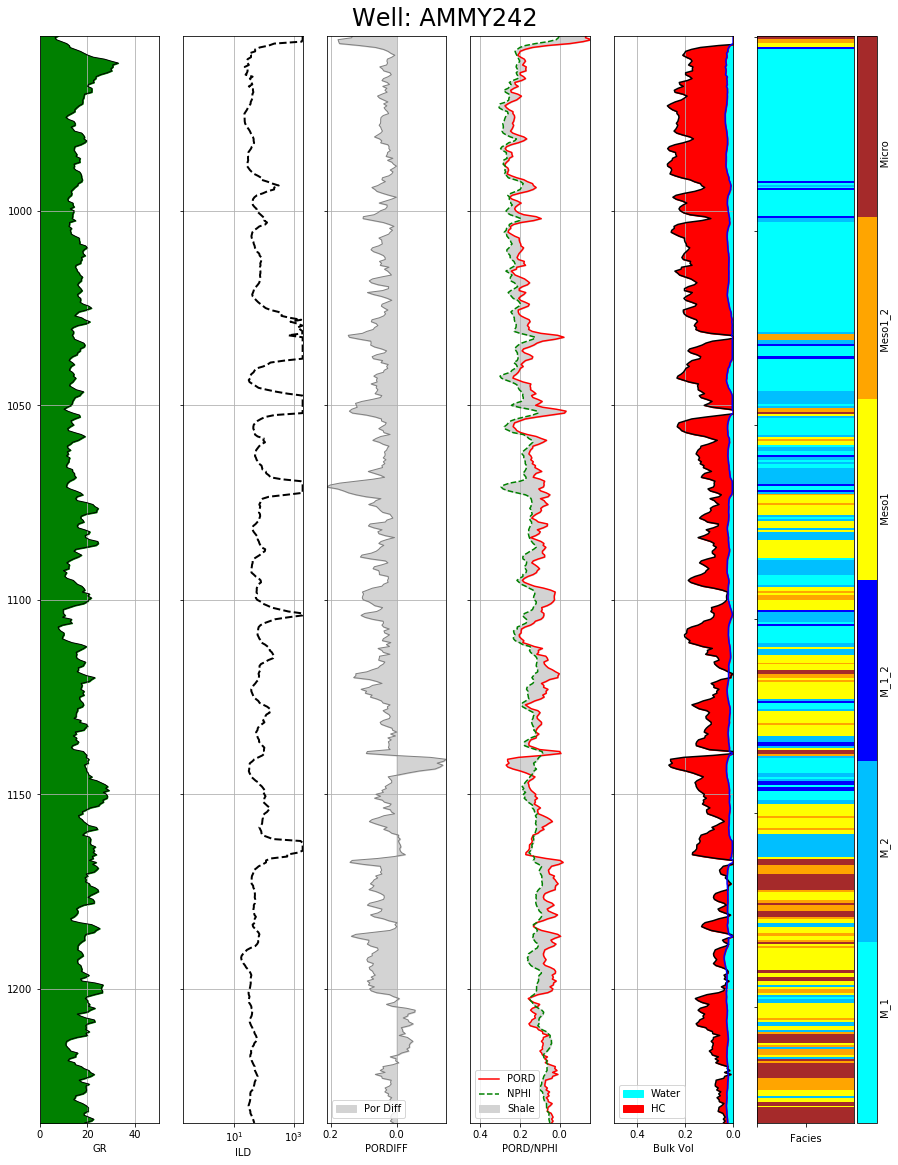

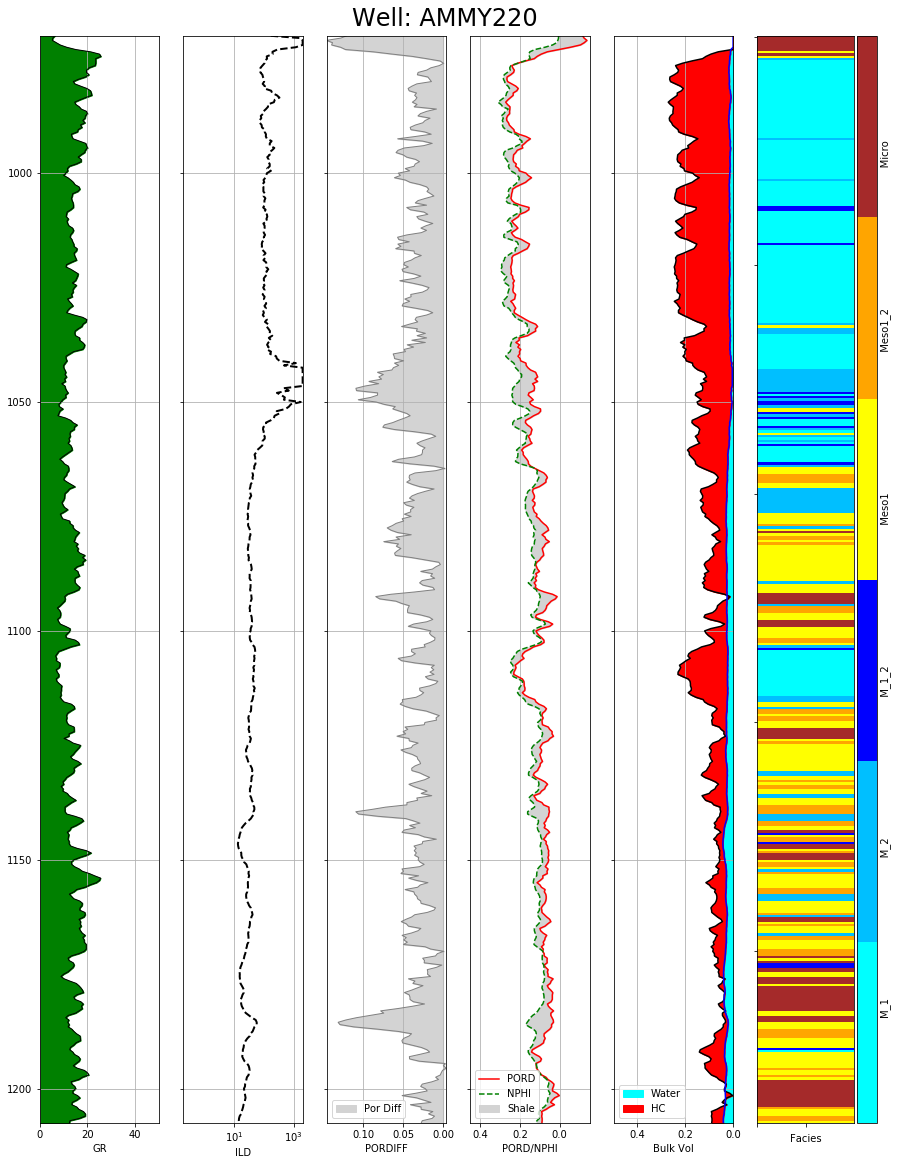

In [7]:


make_facies_log_plot(
    training_data[training_data['Well Name'] == 'AMMY242'],
    facies_colors)

make_facies_log_plot(
    training_data[training_data['Well Name'] == 'AMMY220'],
    facies_colors)



In addition to individual wells, we can look at how the various facies are represented by the entire training set.  Let's plot a histgram of the number of training examples for each facies class.

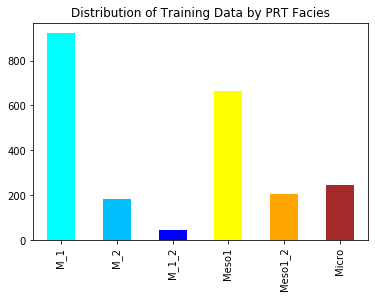

In [8]:
#count the number of unique entries for each facies, sort them by
#facies number (instead of by number of entries)
facies_counts = training_data['Facies'].value_counts().sort_index()
#use facies labels to index each count
facies_counts.index = facies_labels

facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Training Data by PRT Facies')
facies_counts
plt.show()


### Another Depth Plot method where we are still working on plotting PRT colors 

In [9]:
"""
===============================================================================
 === 2. Display the logs in Triple Combo Plot
 
 A triple-combo display will be created in matplotlib in order to
 visualize the curves. The template will be incorporated into the triple
 combo_plot function dependent on the selection of top and bottom depths
 of the graph.
 
 The triple combo display will consist in: - First track: GR, SP, CALI -
 Second track: Resistivities - Third Track: Density, Sonic and Neutronic
 
 In the next code lines, we will set the template.
===============================================================================
"""

# Create the TRIPLE COMBO figure and subplots
def triple_combo_plot(logs, facies_colors):
    
   
    #logs=data[(data.DEPT >= top_depth) & (data.DEPT <= bottom_depth)]
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)    
    
    
    
    #f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))

    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(12,16), sharey=True)
    
    
    
    #fig.suptitle("Well Composite", fontsize=22)
    #fig.subplots_adjust(top=0.75,wspace=0.1)

    #General setting for all axis
    for axes in ax:
        axes.set_ylim (ztop,zbot)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        axes.locator_params(axis='x', nbins=3)
        #for (i,j) in zip(tops_depths,tops):
        #    if ((i>=top_depth) and (i<=bottom_depth)):
        #        axes.axhline(y=i, linewidth=1.0, color='red')
        #        axes.text(0.1, i ,j, horizontalalignment='center',verticalalignment='center', color = 'red')
 
    #    for i in range(len(ax)-1):
    #        ax[i].set_ylim(ztop,zbot)
    #        ax[i].invert_yaxis()
    #        ax[i].grid()
    #        ax[i].locator_params(axis='x', nbins=3)


        
    #1st track: GR, CALI, SP track
   
    ax01=ax[0].twiny()
    ax01.set_xlim(0,50)
    ax01.plot(logs.GR, logs.Depth, label='GR[api]', color='green') 
    ax01.fill_betweenx(logs.Depth,0,logs.GR,color='green',label= 'GR')
    ax01.spines['top'].set_position(('outward',80))
    ax01.set_xlabel('GR[api]',color='green')    
    ax01.tick_params(axis='x', colors='green')
    

    #2nd track: Resistivities
    ax11=ax[1].twiny()
    ax11.set_xlim(0.2,2000)
    ax11.set_xscale('log')
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',80))
    ax11.set_xlabel('ILD[ohmm]', color='black')
    ax11.plot(logs.ILD, logs.Depth, '--', label='ILD[ohmm]',color='black', linewidth=2.0)
    ax11.tick_params(axis='x', colors='black')    
    
    
    #3rd track: Porosity
    
    ax21=ax[2].twiny()
    ax21.set_xlim(-0.15,0.45)
    ax21.invert_xaxis()
    ax21.plot(logs.NPHI, logs.Depth, '--', label='NPHI[v/v]', color='green') 
    ax21.fill_betweenx(logs.Depth,logs.NPHI, logs.PORD,color='lightgray',label= 'Shale')
    ax21.spines['top'].set_position(('outward',40))
    ax21.set_xlabel('NPHI[v/v]', color='green')    
    ax21.tick_params(axis='x', colors='green')

    
    ax22=ax[2].twiny()
    ax22.set_xlim(1.95,2.95)
    ax22.plot(logs.RHOB, logs.Depth ,label='RHOB[g/cc]', color='red') 
    ax22.spines['top'].set_position(('outward',5))
    ax22.set_xlabel('RHOB[g/cc]',color='red')
    ax22.tick_params(axis='x', colors='red') 

    
    ax23=ax[2].twiny()
    ax23.set_xlim(0,0.6)
    ax23.invert_xaxis()
    ax23.plot(logs.PORDIFF, logs.Depth, label='PORDIFF[v/v]', color='black') 
    ax23.fill_betweenx(logs.Depth,0,logs.PORDIFF,color='lightgray',label= 'Por Diff')
    ax23.spines['top'].set_position(('outward',80))
    ax23.set_xlabel('PORDIFF[v/v]', color='black')    
    ax23.tick_params(axis='x', colors='black')
    ax23.legend(loc='lower left')
    
    
    
    
    #4th track: Results
    ax31=ax[3].twiny()
    ax31.set_xlim(0,0.5)
    ax31.invert_xaxis()
    ax31.plot(logs.PORD, logs.Depth, label='PORD[v/v]', color='magenta') 
    ax31.fill_betweenx(logs.Depth,0,logs.BVW,color='cyan',label= 'Water')
    ax31.spines['top'].set_position(('outward',80))
    ax31.set_xlabel('PORD[v/v]', color='magenta')    
    ax31.tick_params(axis='x', colors='magenta') 
   
    ax32=ax[3].twiny()
    ax32.set_xlim(0,0.5)
    ax32.invert_xaxis()
    ax32.plot(logs.BVW, logs.Depth,  color='blue', label='BVW[v/v]') 
    ax32.fill_betweenx(logs.Depth,logs.PORD, logs.BVW,color='red',label= 'HC')
    ax32.spines['top'].set_position(('outward',40))
    ax32.set_xlabel('BVW[v/v]', color='blue')    
    ax32.tick_params(axis='x', colors='blue') 
    ax32.legend(loc='lower left')    

    
    
    # Facies
    ax41=ax[4].twiny()
    ax41.set_xlim(-2,7)
    ax41.invert_xaxis()
    ax41.plot(logs.Facies, logs.Depth, label='Facies', color='black') 
    ax41.fill_betweenx(logs.Depth,7,logs.Facies, color = 'cyan')   
    ax41.spines['top'].set_position(('outward',80))
    ax41.set_xlabel('Facies', color='black')    
    ax41.tick_params(axis='x', colors='black') 
    
    
    
    im=ax41.imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=6)
    
    
    
    divider = make_axes_locatable(ax41)
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)

    cbar.set_label((28*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    
    fig.subplots_adjust(top=0.75,wspace=0.1)
    fig.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24,y=0.94)
    plt.show()
# =============================================================================
#      Display the logs for the whole well
# =============================================================================

#triple_combo_plot(data.DEPT.min(),data.DEPT.max())



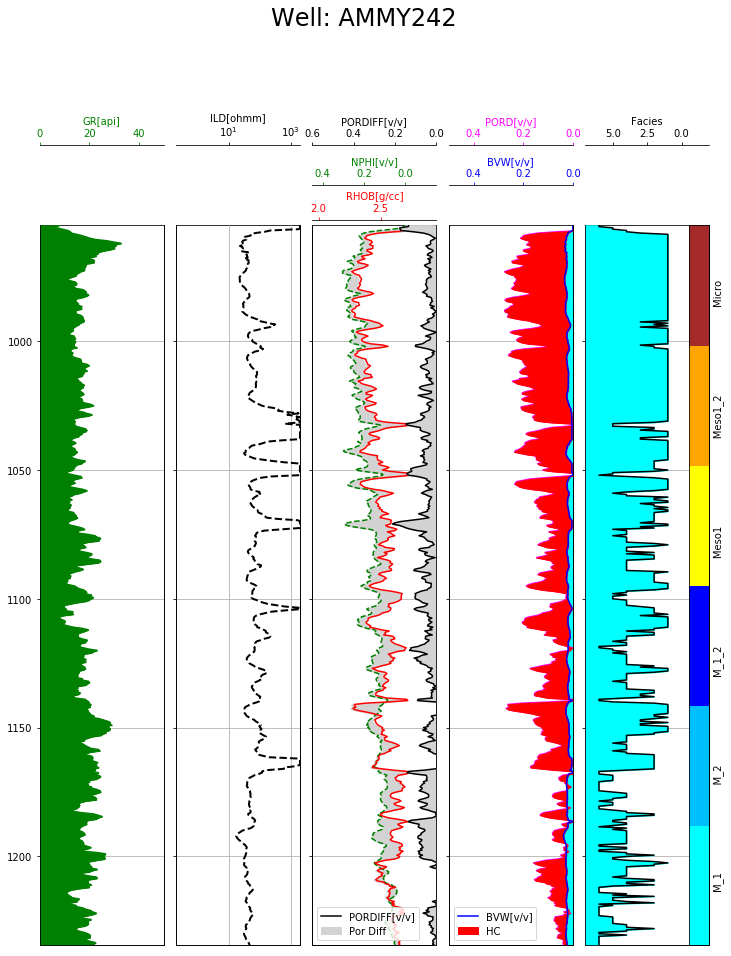

In [10]:
triple_combo_plot(
    training_data[training_data['Well Name'] == 'AMMY242'],
    facies_colors)


This shows the distribution of examples by facies for the 8368 training examples in the training set.  

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains the log variables, and scatter matrix can help to quickly visualize the variation between the all the variables in the dataset.  We can employ the very useful [Seaborn library](https://stanford.edu/~mwaskom/software/seaborn/) to quickly create a nice looking scatter matrix. Each pane in the plot shows the relationship between two of the variables on the x and y axis, with each point is colored according to its facies.  The same colormap is used to represent the 6 PRT facies.  

/Users/craig/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  
/Users/craig/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/craig/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/craig/opt/anaconda3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Us

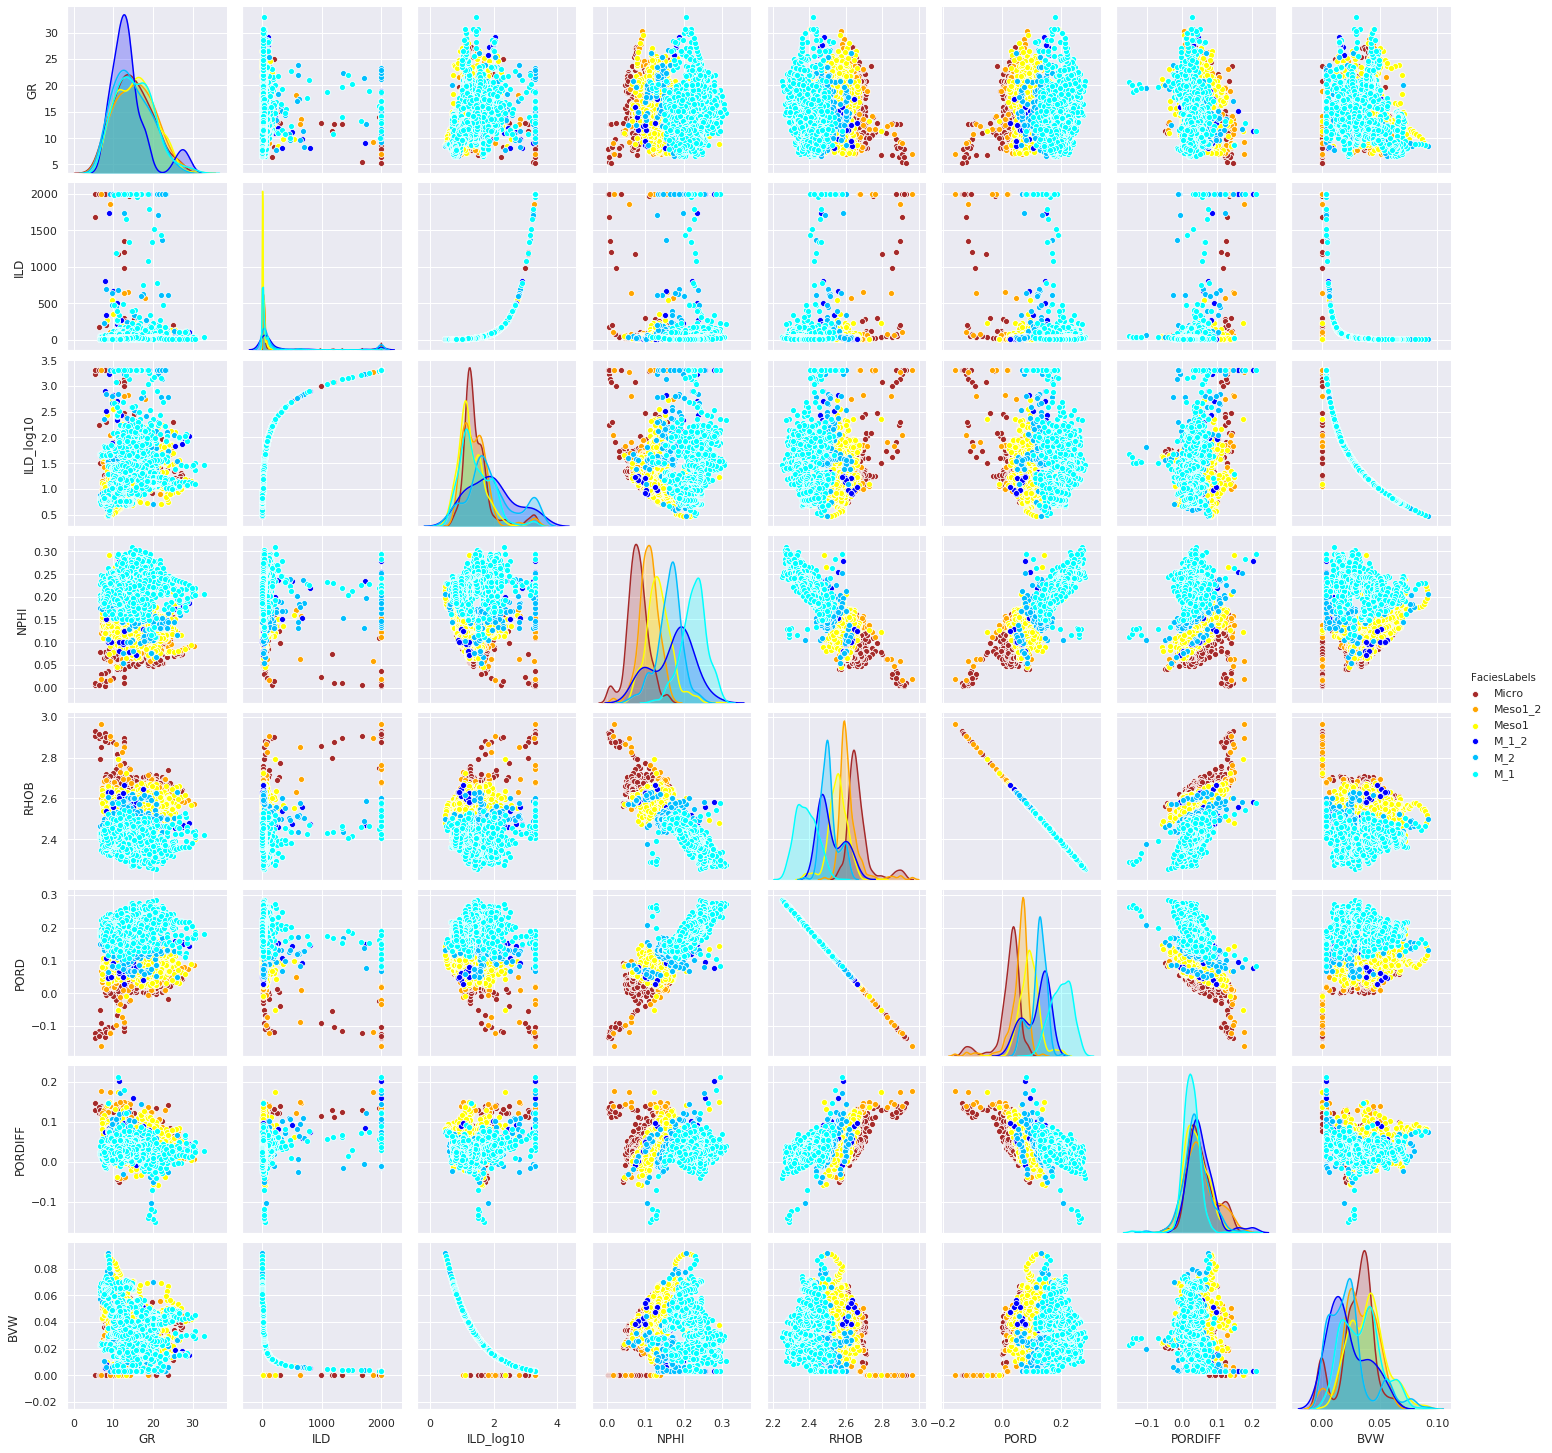

In [11]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(training_data.drop(['Well Name','Facies','Depth'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

## Conditioning the data set

Now we extract just the feature variables we need to perform the classification.  The predictor variables are the  wireline values and PRT which is our vector of the facies labels that correspond to each feature vector.

In [12]:
correct_facies_labels = training_data['Facies'].values

feature_vectors = training_data.drop([ 'Well Name', 'Depth','Facies','BVW','ILD','FaciesLabels'], axis=1)
feature_vectors.describe()

,GR,ILD_log10,NPHI,RHOB,PORD,PORDIFF
count,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000,2269.000000
mean,15.422392,1.446760,0.167161,2.500695,0.130003,0.037158
std,4.787341,0.531470,0.062642,0.117890,0.073224,0.034047
min,5.323100,0.475671,0.002300,2.254000,-0.159503,-0.150453
25%,11.642800,1.101300,0.116800,2.399000,0.073851,0.015727
50%,15.064500,1.322095,0.163400,2.509800,0.124348,0.032793
75%,18.732300,1.685464,0.222000,2.591100,0.193168,0.052256
max,32.888600,3.301030,0.309700,2.966800,0.283230,0.212175


Scikit includes a [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) module that can 'standardize' the data (giving each variable zero mean and unit variance, also called *whitening*).  Many machine learning algorithms assume features will be standard normally distributed data (ie: Gaussian with zero mean and unit variance).  The factors used to standardize the training set must be applied to any subsequent feature set that will be input to the classifier.  The `StandardScalar` class can be fit to the training set, and later used to standardize any training data.

In [13]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

Scikit also includes a handy function to randomly split the training data into training and test sets.  The test set contains a small subset of feature vectors that are not used to train the network.  Because we know the true facies labels for these examples, we can compare the results of the classifier to the actual facies and determine the accuracy of the model.  Let's use 20% of the data for the test set.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.2, random_state=42)

## Training the SVM classifier

Now we use the cleaned and conditioned training set to create a facies classifier.  As mentioned above, we will use a type of machine learning model known as a [support vector machine](https://en.wikipedia.org/wiki/Support_vector_machine).  The SVM is a map of the feature vectors as points in a multi dimensional space, mapped so that examples from different facies are divided by a clear gap that is as wide as possible.  

The SVM implementation in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) takes a number of important parameters.  First we create a classifier using the default settings.  

In [15]:
from sklearn import svm

clf = svm.SVC()

Now we can train the classifier using the training set we created above.

In [16]:
clf.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now that the model has been trained on our data, we can use it to predict the facies of the feature vectors in the test set.  Because we know the true facies labels of the vectors in the test set, we can use the results to evaluate the accuracy of the classifier.

In [17]:
predicted_labels = clf.predict(X_test)

We need some metrics to evaluate how good our classifier is doing.  A [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) is a table that can be used to describe the performance of a classification model.  [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) allows us to easily create a confusion matrix by supplying the actual and predicted facies labels.

The confusion matrix is simply a 2D array.  The entries of confusion matrix `C[i][j]` are equal to the number of observations predicted to have facies `j`, but are known to have facies `i`.  

To simplify reading the confusion matrix, a function has been written to display the matrix along with facies labels and various error metrics.  See the file `classification_utilities.py` in this repo for the `display_cm()` function.

In [18]:
from sklearn.metrics import confusion_matrix
from classification_utilities import display_cm, display_adj_cm

conf = confusion_matrix(y_test, predicted_labels)
#print(conf)


display_cm(conf, facies_labels, hide_zeros=True)




     Pred >     M_1     M_2   M_1_2   Meso1 Meso1_2   Micro   Total 
     True
        M_1     185       3               5                     193 
        M_2      13      12               5                      30 
      M_1_2       4       3               3                      10 
      Meso1       7       3             113               7     130 
    Meso1_2                              31       3       3      37 
      Micro                              11       3      40      54 


/Users/craig/Documents/GitHub/ArabD_GitHub/PRT_Geolog_help/classification_utilities.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')


The rows of the confusion matrix correspond to the actual facies labels.  The columns correspond to the labels assigned by the classifier.  For example, consider the first row. For the feature vectors in the test set that actually have label `SS`, 23 were correctly indentified as `SS`, 21 were classified as `CSiS` and 2 were classified as `FSiS`.

The entries along the diagonal are the facies that have been correctly classified.  Below we define two functions that will give an overall value for how the algorithm is performing.  The accuracy is defined as the number of correct classifications divided by the total number of classifications.

In [19]:
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

As noted above, the boundaries between the facies classes are not all sharp, and some of them blend into one another.  The error within these 'adjacent facies' can also be calculated.  We define an array to represent the facies adjacent to each other.  For facies label `i`, `adjacent_facies[i]` is an array of the adjacent facies labels.

In [20]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,5]])

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

In [21]:
print( 'Facies classification accuracy = %f' % accuracy(conf))
print( 'Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

Facies classification accuracy = 0.777533
Adjacent facies classification accuracy = 0.988987


## Model parameter selection

The classifier so far has been built with the default parameters.  However, we may be able to get improved classification results with optimal parameter choices.

We will consider two parameters.  The parameter `C` is a regularization factor, and tells the classifier how much we want to avoid misclassifying training examples.  A large value of C will try to correctly classify more examples from the training set, but if `C` is too large  it may 'overfit' the data and fail to generalize when classifying new data. If `C` is too small then the model will not be good at fitting outliers and will have a large error on the training set.

The SVM learning algorithm uses a kernel function to compute the distance between feature vectors.  Many kernel functions exist, but in this case we are using the radial basis function `rbf` kernel (the default).  The `gamma` parameter describes the size of the radial basis functions, which is how far away two vectors in the feature space need to be to be considered close.

We will train a series of classifiers with different values for `C` and `gamma`.  Two nested loops are used to train a classifier for every possible combination of values in the ranges specified.  The classification accuracy is recorded for each combination of parameter values.  The results are shown in a series of plots, so the parameter values that give the best classification accuracy on the test set can be selected.

This process is also known as 'cross validation'.  Often a separate 'cross validation' dataset will be created in addition to the training and test sets to do model selection.  For this tutorial we will just use the test set to choose model parameters.

In [22]:
#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = False
#do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(20,36))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = plot_number / 2
        column = plot_number % 2
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C = c_value, gamma = gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)
        #ax = axes[row, column]
        ax = fig.add_subplot(3, 2,plot_number+1 )
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1])
        
    ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=14)
             
    fig.text(0.04, 0.5, 'Classification Accuracy', va='center', 
             rotation='vertical', fontsize=14)

In [23]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])



####clf.fit(X_train,y_train)
X=X_train
y=y_train

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))


The best parameters are {'C': 100.0, 'gamma': 0.1} with a score of 0.81


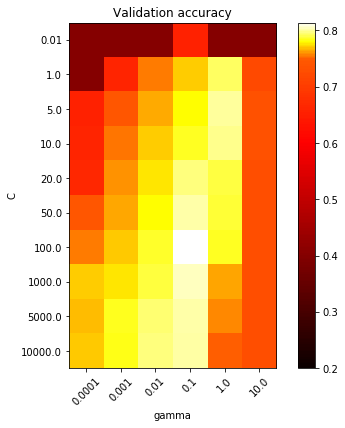

In [24]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.75))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

From the above heamap the best accuracy on the cross validation error curve was achieved for `C = 100` and `gamma = 0.1`.  We can now create and train an optimized classifier based on these parameters:

In [25]:
# gamma Defines how far the influence of a single training example reach. The gamma parameters can be seen 
# as the inverse of the radius of influence of samples selected by the model as support vectors
GAMMA=0.1


# C behaves as a regularization parameter in the SVM.  For larger values of C, a smaller margin will be accepted 
# if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.
C_REG = 100

clf = svm.SVC(C = C_REG, gamma = GAMMA)  

clf.fit(X_train,y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))

print( 'Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print( 'Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.81
Optimized adjacent facies classification accuracy = 1.00


In [26]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 100.0, 'gamma': 0.1} with a score of 0.81


[Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) are metrics that give more insight into how the classifier performs for individual facies.  Precision is the probability that given a classification result for a sample, the sample actually belongs to that class.  Recall is the probability that a sample will be correctly classified for a given class.

Precision and recall can be computed easily using the confusion matrix.  The code to do so has been added to the `display_confusion_matrix()` function:

In [27]:
display_cm(cv_conf, facies_labels, 
           display_metrics=True, hide_zeros=True)


     Pred >     M_1     M_2   M_1_2   Meso1 Meso1_2   Micro   Total 
     True
        M_1     186       4       2       1                     193 
        M_2       6      22               1       1              30 
      M_1_2       4       2               2       2              10 
      Meso1      11       3              99      14       3     130 
    Meso1_2                              14      21       2      37 
      Micro                               7       8      39      54 

Precision    0.90    0.71    0.00    0.80    0.46    0.89    0.80 
   Recall    0.96    0.73    0.00    0.76    0.57    0.72    0.81 
       F1    0.93    0.72    0.00    0.78    0.51    0.80    0.80 


/Users/craig/Documents/GitHub/ArabD_GitHub/PRT_Geolog_help/classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


To interpret these results, consider facies `M_1`.  In our test set, if a sample was labeled `M_1` the probability the sample was correct is 0.8 (precision).  If we know a sample has facies `M_1`, then the probability it will be correctly labeled by the classifier is 0.78 (recall).  It is desirable to have high values for both precision and recall, but often when an algorithm is tuned to increase one, the other decreases.  The [F1 score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure) combines both to give a single measure of relevancy of the classifier results.

We can also consider the classification metrics when we consider misclassifying an adjacent facies as correct:


In [28]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, 
           display_metrics=True, hide_zeros=True)


     Pred >     M_1     M_2   M_1_2   Meso1 Meso1_2   Micro   Total 
     True
        M_1     190               2       1                     193 
        M_2              28               1       1              30 
      M_1_2       4               2       2       2              10 
      Meso1      11       3             113               3     130 
    Meso1_2                                      37              37 
      Micro                               7                       7 

Precision    0.93    0.90    0.50    0.91    0.93    0.00    0.89 
   Recall    0.98    0.93    0.20    0.87    1.00    0.00    0.91 
       F1    0.95    0.92    0.29    0.89    0.96    0.00    0.90 


Considering adjacent facies, the `F1` scores for all facies types are above 0.9, except when classifying PRTs. 

These results are comparable to those reported in Dubois et al. (2007).

# Applying the classification model to the blind well data

We held a well back from the training, and stored it in a dataframe called `blind`:

In [29]:
blind

,Facies,Well Name,Depth,GR,ILD,ILD_log10,NPHI,RHOB,PORD,PORDIFF,BVW
1476,6,AMMY137,1671.0,10.6677,764.746,2.883517,0.0531,2.7893,-0.049255,0.102355,0.000000
1477,6,AMMY137,1671.5,11.6808,1038.405,3.016367,0.0453,2.8161,-0.065901,0.111201,0.000000
1478,6,AMMY137,1672.0,11.9095,638.250,2.804991,0.0403,2.8332,-0.076522,0.116822,0.000000
1479,6,AMMY137,1672.5,11.4480,173.001,2.238049,0.0418,2.8468,-0.084969,0.126769,0.000000
1480,6,AMMY137,1673.0,10.5700,113.929,2.056634,0.0622,2.8162,-0.065963,0.128163,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1959,5,AMMY137,1912.5,21.4097,14.573,1.163549,0.1058,2.5804,0.080497,0.025303,0.041419
1960,5,AMMY137,1913.0,20.6272,15.401,1.187549,0.1024,2.5777,0.082174,0.020226,0.040290
1961,5,AMMY137,1913.5,19.8105,16.050,1.205475,0.0986,2.5738,0.084596,0.014004,0.039467
1962,5,AMMY137,1914.0,19.7872,16.204,1.209622,0.0952,2.5741,0.084410,0.010790,0.039279


The label vector is just the `Facies` column:

In [30]:
y_blind = blind['Facies'].values

We can form the feature matrix by dropping some of the columns and making a new dataframe:

In [31]:
well_features = blind.drop(['Facies',  'Well Name', 'Depth','ILD','BVW'], axis=1)



Now we can transform this with the scaler we made before:

In [32]:
X_blind = scaler.transform(well_features)

Now it's a simple matter of making a prediction and storing it back in the dataframe:

In [33]:
y_pred = clf.predict(X_blind)
blind['Prediction'] = y_pred

/Users/craig/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's see how we did with the confusion matrix:

In [34]:
cv_conf = confusion_matrix(y_blind, y_pred)

print( 'Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print( 'Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))

Optimized facies classification accuracy = 0.78
Optimized adjacent facies classification accuracy = 0.94


We managed 0.75 using the test data, but it was from the same wells as the training data. This more reasonable test does not perform as well... but does remarkably well on the adjacent facies predictions. 

In [35]:
display_adj_cm(cv_conf, facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)


     Pred >     M_1     M_2   M_1_2   Meso1 Meso1_2   Micro   Total 
     True
        M_1     258                       5                     263 
        M_2              13               5       1              19 
      M_1_2       1                       4               2       7 
      Meso1      35       2              77               9     123 
    Meso1_2                                      33              33 
      Micro                               4                       4 

Precision    0.88    0.87    0.00    0.81    0.97    0.00    0.84 
   Recall    0.98    0.68    0.00    0.63    1.00    0.00    0.85 
       F1    0.93    0.76    0.00    0.71    0.99    0.00    0.84 


/Users/craig/Documents/GitHub/ArabD_GitHub/PRT_Geolog_help/classification_utilities.py:10: RuntimeWarning: invalid value encountered in true_divide
  precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
/Users/craig/Documents/GitHub/ArabD_GitHub/PRT_Geolog_help/classification_utilities.py:12: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2 * (precision * recall) / (precision + recall)


In [36]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    #cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)

    
    
    
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 16))
    ax[0].plot(logs.GR, logs.Depth, 'k-', linewidth=1.0)
    ax[1].plot(logs.ILD, logs.Depth, 'k--', linewidth=2.0)
    ax[2].plot(logs.PORDIFF, logs.Depth, '-', color='0.5', linewidth=1.0)
    ax[3].plot(logs.PORD, logs.Depth, '-', color='r', label= 'PORD')
    ax[3].plot(logs.NPHI, logs.Depth, 'g--',label= 'NPHI')
    ax[4].plot(logs.PORD, logs.Depth, '-', color='black')
    ax[4].plot(logs.BVW, logs.Depth, '-', color='blue')
    
    
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=6)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=6)
    
    
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)

    cbar.set_label((35*' ').join(facies_labels))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0,50)
    ax[0].fill_betweenx(logs.Depth,0,logs.GR,color='green',label= 'GR')

    ax[1].set_xscale('log')
    ax[1].set_xlabel("ILD")
    ax[1].set_xlim(.2,2000)

    ax[2].set_xlabel("PORDIFF")
    ax[2].set_xlim(logs.PORDIFF.max(),logs.PORDIFF.min())
    ax[2].fill_betweenx(logs.Depth,0,logs.PORDIFF,color='lightgray',label= 'Por Diff')
    ax[2].legend(loc='lower left') 

    
    
    ax[3].set_xlabel("PORD/NPHI")
    ax[3].set_xlim(.45,-0.15)
    ax[3].fill_betweenx(logs.Depth,logs.NPHI, logs.PORD,color='lightgray',label= 'Shale')
    ax[3].legend(loc='lower left') 

    ax[4].set_xlabel("Bulk Vol")
    ax[4].set_xlim(.5,0)
    ax[4].fill_betweenx(logs.Depth,0,logs.BVW,color='cyan',label= 'Water')
    ax[4].fill_betweenx(logs.Depth,logs.PORD, logs.BVW,color='red',label= 'HC')
    ax[4].legend(loc='lower left') 


    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=24,y=0.94)

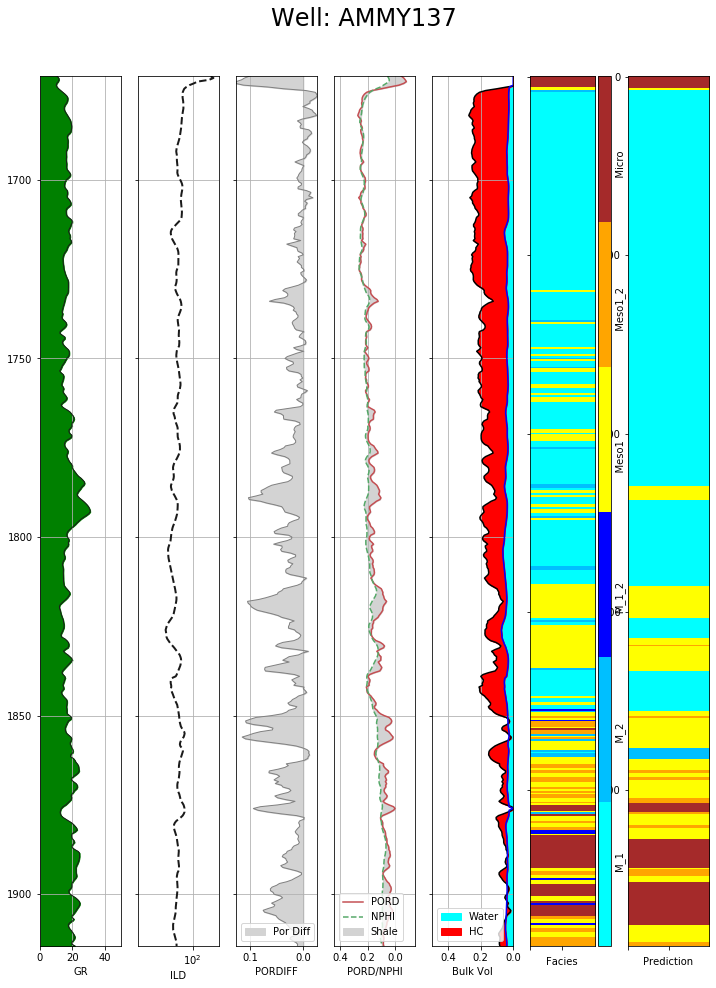

In [37]:
compare_facies_plot(blind, 'Prediction', facies_colors)

## Applying the classification model to new data

Now that we have a trained facies classification model we can use it to identify facies in wells that do not have core data.  In this case, we will apply the classifier to two wells, but we could use it on any number of wells for which we have the same set of well logs for input.

This dataset is similar to the training data except it does not have facies labels.  It is loaded into a dataframe called `test_data`.

In [38]:
well_data = pd.read_csv('./data/AMMY_validation_data_nofacies_notops.csv')
well_data['Well Name'] = well_data['Well Name'].astype('category')
well_features = well_data.drop(['Well Name', 'Depth','BVW','ILD'], axis=1)

The data needs to be scaled using the same constants we used for the training data.

In [39]:
X_unknown = scaler.transform(well_features)

Finally we predict facies labels for the unknown data, and store the results in a `Facies` column of the `test_data` dataframe.

In [40]:
#predict facies of unclassified data
y_unknown = clf.predict(X_unknown)
well_data['Facies'] = y_unknown
well_data

,Well Name,Depth,GR,ILD,ILD_log10,NPHI,RHOB,PORD,PORDIFF,BVW,Facies
0,AMMY230,946.4399,16.8128,1551.872,3.190856,0.0399,2.8920,-0.113043,0.152943,0.000000,5
1,AMMY230,946.9399,18.7793,1487.950,3.172588,0.0875,2.8576,-0.091677,0.179177,0.000000,5
2,AMMY230,947.4399,20.6849,1279.891,3.107173,0.1352,2.7568,-0.029068,0.164268,0.000000,6
3,AMMY230,947.9399,22.5678,398.702,2.600648,0.1709,2.6161,0.058323,0.112577,0.007919,5
4,AMMY230,948.4399,24.2175,264.338,2.422160,0.1842,2.4988,0.131180,0.053020,0.009725,1
...,...,...,...,...,...,...,...,...,...,...,...
1095,AMMY196,1994.7800,15.9162,10.009,1.000391,0.0945,2.6012,0.067578,0.026922,0.049978,5
1096,AMMY196,1995.2800,15.6304,9.806,0.991492,0.0852,2.6275,0.051242,0.033958,0.050492,6
1097,AMMY196,1995.7800,15.4719,9.770,0.989895,0.0801,2.6528,0.035528,0.044572,0.050585,6
1098,AMMY196,1996.2800,15.4230,10.014,1.000608,0.0774,2.6647,0.028137,0.049263,0.049965,6


In [41]:
well_data['Well Name'].unique()

[AMMY230, AMMY196]
Categories (2, object): [AMMY230, AMMY196]

In [42]:
well_data

,Well Name,Depth,GR,ILD,ILD_log10,NPHI,RHOB,PORD,PORDIFF,BVW,Facies
0,AMMY230,946.4399,16.8128,1551.872,3.190856,0.0399,2.8920,-0.113043,0.152943,0.000000,5
1,AMMY230,946.9399,18.7793,1487.950,3.172588,0.0875,2.8576,-0.091677,0.179177,0.000000,5
2,AMMY230,947.4399,20.6849,1279.891,3.107173,0.1352,2.7568,-0.029068,0.164268,0.000000,6
3,AMMY230,947.9399,22.5678,398.702,2.600648,0.1709,2.6161,0.058323,0.112577,0.007919,5
4,AMMY230,948.4399,24.2175,264.338,2.422160,0.1842,2.4988,0.131180,0.053020,0.009725,1
...,...,...,...,...,...,...,...,...,...,...,...
1095,AMMY196,1994.7800,15.9162,10.009,1.000391,0.0945,2.6012,0.067578,0.026922,0.049978,5
1096,AMMY196,1995.2800,15.6304,9.806,0.991492,0.0852,2.6275,0.051242,0.033958,0.050492,6
1097,AMMY196,1995.7800,15.4719,9.770,0.989895,0.0801,2.6528,0.035528,0.044572,0.050585,6
1098,AMMY196,1996.2800,15.4230,10.014,1.000608,0.0774,2.6647,0.028137,0.049263,0.049965,6


We can use the well log plot to view the classification results along with the well logs.

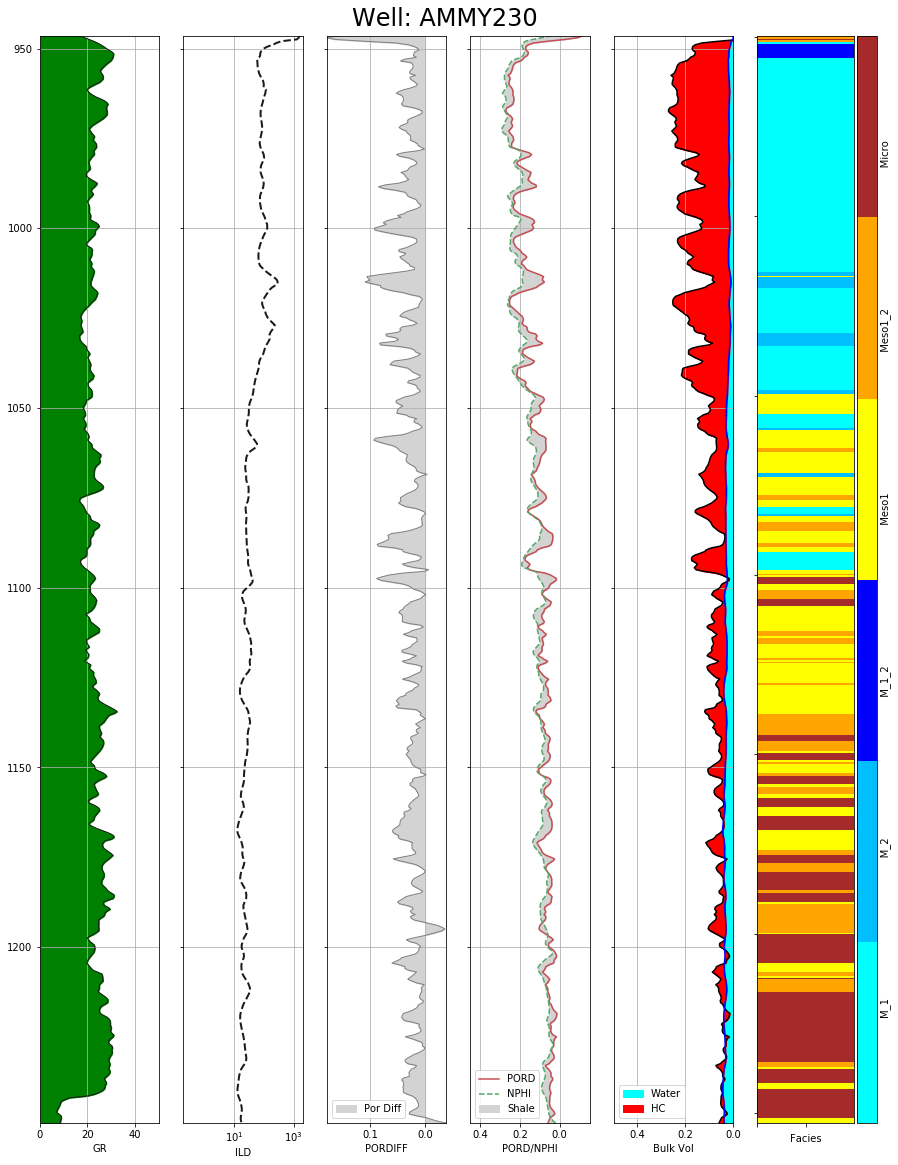

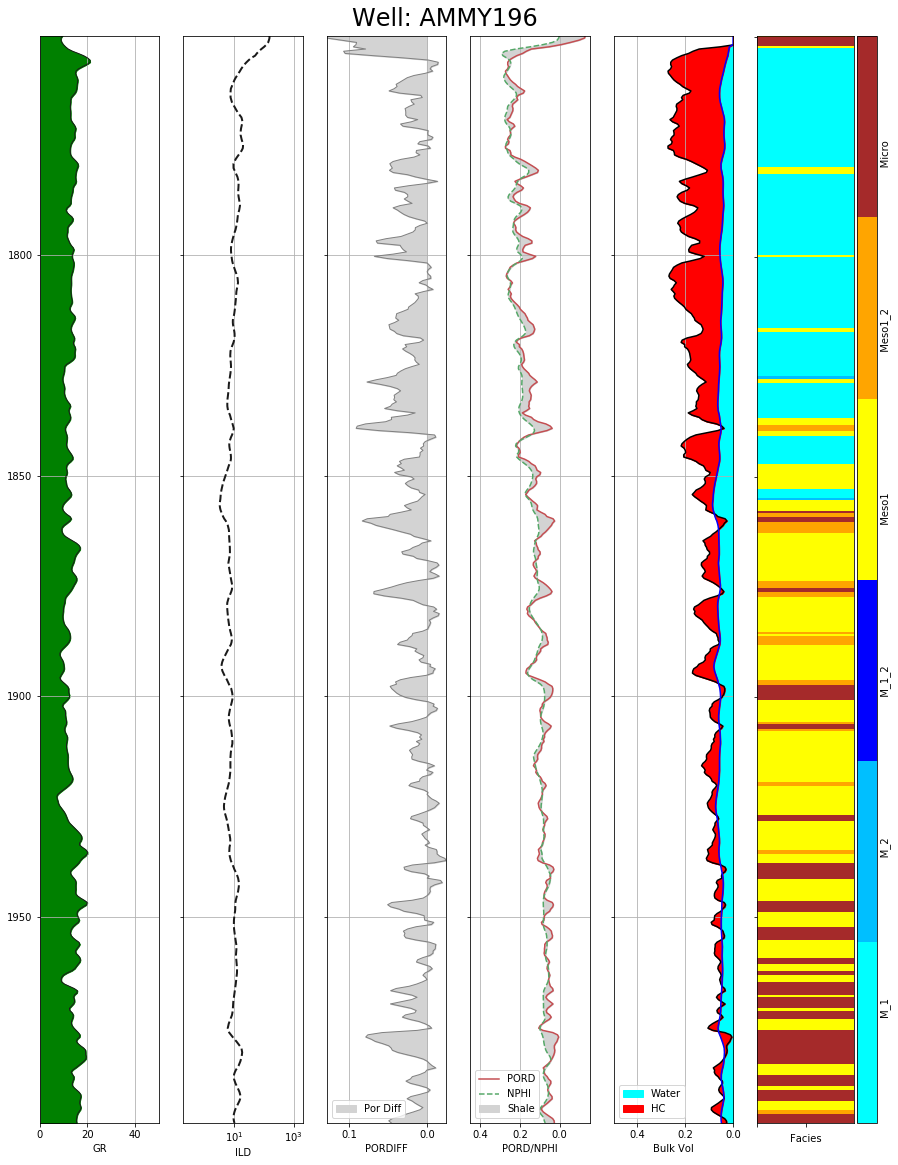

In [43]:
make_facies_log_plot(
    well_data[well_data['Well Name'] == 'AMMY230'],
    facies_colors=facies_colors)

make_facies_log_plot(
    well_data[well_data['Well Name'] == 'AMMY196'],
    facies_colors=facies_colors)


Finally we can write out a csv file with the well data along with the facies classification results.

In [44]:
well_data.to_csv('./data/well_data_with_facies.csv')

### This is the original Depth Plot

## References



1.	Hall, Brendon, “Facies classification using Machine Learning”, The Leading Edge, 2016, Volume 35, Issue 10

2.	Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October, 2008. 



Amato del Monte, A., 2015. Seismic Petrophysics: Part 1, *The Leading Edge*, 34 (4). [doi:10.1190/tle34040440.1](http://dx.doi.org/10.1190/tle34040440.1)

Bohling, G. C., and M. K. Dubois, 2003. An Integrated Application of Neural Network and Markov Chain Techniques to Prediction of Lithofacies from Well Logs, *KGS Open-File Report* 2003-50, 6 pp. [pdf](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf)

Dubois, M. K., G. C. Bohling, and S. Chakrabarti, 2007, Comparison of four approaches to a rock facies classification problem, *Computers & Geosciences*, 33 (5), 599-617 pp. [doi:10.1016/j.cageo.2006.08.011](http://dx.doi.org/10.1016/j.cageo.2006.08.011)
